In [ ]:
# Copyright 2020 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/compute/machine-learning/frameworks/nvidia_logo.png" style="width: 90px; float: right;">

# MovieLens: NVTabular for MultiHot Categories on MovieLens25M

## Overview

NVTabular is a feature engineering and preprocessing library for tabular data designed to quickly and easily manipulate terabyte scale datasets used to train deep learning based recommender systems.  It provides a high level abstraction to simplify code and accelerates computation on the GPU using the RAPIDS cuDF library.<br><br>
One challenge in recommender systems (tabular data) are multi-hot categorical features. A product can have multiple categories assigned, but the number of categories per product varies. For example, a movie can have one or multiple genres:<br>
Father of the Bride Part II: \[Comedy\]<br>
Toy Story: \[Adventure, Animation, Children, Comedy, Fantasy\]<br>
Jumanji: \[Adventure, Children, Fantasy\]<br><br>
One strategy is often to use only the first category or the most frequent ones. However, a better strategy is to use all provided categories per datapoint. [RAPID cuDF](https://github.com/rapidsai/cudf) added list support in its [latest release v0.16](https://medium.com/rapids-ai/two-years-in-a-snap-rapids-0-16-ae797795a5c4). NVTabular implemented support for multi-hot categorical features. In this notebook, we take a look on how to add multi-hot categorical features to our deep learning model in TensorFlow.

### Learning objectives

This notebook explains, how to use multi-hot categorical features in a deep learning model.
1. Preprocess multi-hot categorical features with **NVTabular**. Deep learning models require continuous integers for embedding layers. Preprocessing multi-hot categorical features are more complicated than single-hot ones.
2. Add multi-hot categorical features to your deep learning model in TensorFlow 

### MovieLens25M

The [MovieLens25M](https://grouplens.org/datasets/movielens/25m/) is a popular dataset for recommender systems and is used in academic publications. The dataset contains 25M movie ratings for 62,000 movies given by 162,000 users. Many projects use only the user/item/rating information of MovieLens, but the original dataset provides metadata for the movies, as well. For example, which genres a movie has. Although we may not improve state-of-the-art results with our neural network architecture, the purpose of this notebook is to explain how to integrate multi-hot categorical features into a neural network.

## Getting Started

In [1]:
# External dependencies
import os
import cudf                 # cuDF is an implementation of Pandas-like Dataframe on GPU
import time
import gc

import pandas as pd
import nvtabular as nvt

from os import path
from sklearn.model_selection import train_test_split

In [2]:
# path to store raw and preprocesses data
BASE_DIR = '/working_dir/data/'

We define our base directory, containing the data.

If the data is not available in the base directory, we will download and unzip the data.

In [3]:
if not path.exists(BASE_DIR + 'ml-25m'):
    if not path.exists(BASE_DIR + 'ml-25m.zip'):
        os.system("wget http://files.grouplens.org/datasets/movielens/ml-25m.zip")
        os.system("mv ml-25m.zip " + BASE_DIR)
    os.system("unzip " + BASE_DIR + "ml-25m.zip -d " + BASE_DIR)

## Preparing the dataset with NVTabular

First, we take a look on the movie metadata. 

We load the movie ratings.

In [5]:
ratings = cudf.read_csv(os.path.join(BASE_DIR, "ml-25m", "ratings.csv"))
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


We drop the timestamp column and split the ratings into training and test dataset. We use a simple random split, as this is a demonstration of multi-hot encoding.

In [6]:
ratings = ratings.drop('timestamp', axis=1)
train, valid = train_test_split(ratings, test_size=0.2, random_state=42)

In [7]:
train.head()

,userId,movieId,rating
19120594,124027,56587,4.0
15253127,98809,2641,2.5
12584278,81377,122886,4.5
18034326,116853,78499,4.5
18073299,117118,1302,2.5


In [8]:
train.shape

(20000076, 3)

First, we need to define our NVTabular processing pipelines. NVTabular has already implemented multiple calculations, called `ops`. An `op` can be applied to a `ColumnGroup` from an overloaded `>>` operator, which in turn returns a new `ColumnGroup`. A `ColumnGroup` is a list of column names as text.<br><br>
**Example:**<br>
features = [*\<column name\>*, ...] >> *\<op1\>* >> *\<op2\>* >> ...

Embedding Layers of neural networks require, that categorial features are continuous, incremental Integers: 0, 1, 2, ... , |C|-1. We need to ensure that our categorical features fullfil the requirement.<br>

We should transform the single-hot categorical features userId and movieId.<br>

NVTabular provides the operator `Categorify`, which provides this functionality with a high-level API out of the box. In NVTabular release v0.3, list support was added for multi-hot categorical features. Both works in the same way with no need for changes.

Next, we will add `Categorify`  for our categorical features, userId, movieId.

In [9]:
cat_names = ['userId', 'movieId']
cat_features = cat_names >> nvt.ops.Categorify()

The ratings are on a scale between 1-5. We want to predict a binary target with 1 are all ratings `>=4` and 0 are all ratings `<=3`. We use the [LambdaOp](https://nvidia.github.io/NVTabular/main/api/ops/lambdaop.html) for it.

In [10]:
ratings = nvt.ColumnGroup(['rating']) >> (lambda col: (col>3).astype('int8'))

We can visualize our calculation graph.

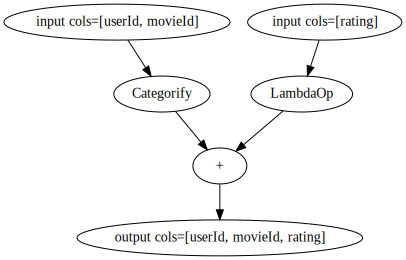

In [11]:
output = cat_features+ratings
(output).graph

We initialize our NVTabular `workflow`.

In [12]:
workflow = nvt.Workflow(output)

We initialize NVTabular Datasets. First, we save it to a parquet file, that we can use the `part_size` parameter in `nvt.Dataset`. When the dataset contains a multi-hot feature, the workflow will write one file per partition. We want to have multiple output files and therefore, we need to use multiple partition by loading the dataset from disk. 

In [13]:
train.to_parquet(BASE_DIR + 'train.parquet')
valid.to_parquet(BASE_DIR + 'valid.parquet')

del train
del valid
gc.collect()

0

In [14]:
train_iter = nvt.Dataset(BASE_DIR + 'train.parquet', part_size='100MB')
valid_iter = nvt.Dataset(BASE_DIR + 'valid.parquet', part_size='100MB')

First, we collect the training dataset statistics.

In [15]:
%%time

workflow.fit(train_iter)

CPU times: user 1.18 s, sys: 381 ms, total: 1.56 s
Wall time: 1.57 s


We clear our output directories.

In [16]:
!rm -r $BASE_DIR/train
!rm -r $BASE_DIR/valid

We transform our workflow with `.transform`.

In [17]:
%time

workflow.transform(train_iter).to_parquet(output_path=BASE_DIR + 'train/')
workflow.transform(valid_iter).to_parquet(output_path=BASE_DIR + 'valid/', shuffle=False)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 9.78 µs


We can take a look in the output dir.

In [18]:
!ls $BASE_DIR/train

0.e4bb575f2c5645e9a30897103f9fbb20.parquet  _metadata
_file_list.txt				    _metadata.json


## TensorFlow: Training Neural Network with Multi-Hot categorical

### Reviewing data

We can take a look on the data.

In [4]:
import glob

TRAIN_PATHS = sorted(glob.glob(BASE_DIR + 'train/*.parquet'))
VALID_PATHS = sorted(glob.glob(BASE_DIR + 'valid/*.parquet'))
TRAIN_PATHS, VALID_PATHS

(['/working_dir/data/train/0.e4bb575f2c5645e9a30897103f9fbb20.parquet'],
 ['/working_dir/data/valid/0.beec2cdbd4df4fba9a197bef0950f666.parquet'])

We can see that our ratings are of only 0 and 1 after preprocessing.

In [6]:
df = cudf.read_parquet(TRAIN_PATHS[0])
df.head()

,userId,movieId,rating
0,124027,11994,1
1,98809,2550,0
2,81377,24262,1
3,116853,14786,1
4,117118,1269,0


In [ ]:
del df
gc.collect()

At this step we are going to generate config.pbtxt and we will save our workflow as a .pkl file to be able to load again to do transformation for the test (new coming) datasets at inference stage. This step actually does the serialization of the workflow that we created above using the training set.

In [27]:
from nvtabular.inference.triton import generate_triton_model
generate_triton_model(workflow, "movielens_nvt", "/home/ronayak/ronaya/models/movielens_nvt/")

Now we will train a TF MLP model using our preprocessed parquet files.

### Defining Hyperparameters

First, we define the data schema and differentiate between single-hot and multi-hot categorical features. Note, that we do not have any numerical input features. 

In [4]:
BATCH_SIZE = 1024*32                            # Batch Size
CATEGORICAL_COLUMNS = ['movieId', 'userId']     # Single-hot
NUMERIC_COLUMNS = []

We get the embedding input and output dimensions.

We will use emb_dim 64 for each categorical features.

In [5]:
EMBEDDING_TABLE_SHAPES = {'movieId': (56586, 64), 'userId': (162542, 64)}

### Initializing NVTabular Data Loader for Tensorflow

We import TensorFlow and some external dependencies, such as custom TensorFlow layers supporting multi-hot and the NVTabular TensorFlow data loader.

In [6]:
import os, time
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

import tensorflow as tf

from tensorflow.python.feature_column import feature_column_v2 as fc

# we can control how much memory to give tensorflow with this environment variable
# IMPORTANT: make sure you do this before you initialize TF's runtime, otherwise
# TF will have claimed all free GPU memory
os.environ['TF_MEMORY_ALLOCATION'] = "0.7" # fraction of free memory
from nvtabular.loader.tensorflow import KerasSequenceLoader, KerasSequenceValidater
from nvtabular.framework_utils.tensorflow import layers
from tensorflow.python.feature_column import feature_column_v2 as fc

First, we take a look on our data loader and how the data is represented as tensors. The NVTabular data loader are initialized and we specify single-hot categorical features as cat_names.

In [7]:
train_dataset_tf = KerasSequenceLoader(
    TRAIN_PATHS, # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=['rating'],
    cat_names=CATEGORICAL_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=True,
    buffer_size=0.06, # how many batches to load at once
    parts_per_chunk=1
)

valid_dataset_tf = KerasSequenceLoader(
    VALID_PATHS, # you could also use a glob pattern
    batch_size=BATCH_SIZE,
    label_names=['rating'],
    cat_names = CATEGORICAL_COLUMNS,
    cont_names=NUMERIC_COLUMNS,
    engine='parquet',
    shuffle=False,
    buffer_size=0.06,
    parts_per_chunk=1
)

### Defining Neural Network Architecture

We will define a common neural network architecture for tabular data.
* Single-hot categorical features are fed into an Embedding Layer
* The output of the Embedding Layers are concatenated
* The concatenated layers are fed through multiple feed-forward layers (Dense Layers with ReLU activations)
* The final output is a single number with sigmoid activation function

First, we will define some dictonary/lists for our network architecture.

In [8]:
inputs = {}    # tf.keras.Input placeholders for each feature to be used
emb_layers = []# output of all embedding layers, which will be concatenated

We create `tf.keras.Input` tensors for all 4 input features.

In [9]:
for col in CATEGORICAL_COLUMNS:
    inputs[col] =  tf.keras.Input(
        name=col,
        dtype=tf.int32,
        shape=(1,)
    )

Next, we initialize Embedding Layers with `tf.feature_column.embedding_column`.

In [10]:
for col in CATEGORICAL_COLUMNS:

    emb_layers.append(
        tf.feature_column.embedding_column(
            tf.feature_column.categorical_column_with_identity(
                col, 
                EMBEDDING_TABLE_SHAPES[col][0]                    # Input dimension (vocab size)
            ), EMBEDDING_TABLE_SHAPES[col][1]                     # Embedding output dimension
        )
    )
emb_layers

[EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='movieId', number_buckets=56586, default_value=None), dimension=64, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f64c88821c0>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True),
 EmbeddingColumn(categorical_column=IdentityCategoricalColumn(key='userId', number_buckets=162542, default_value=None), dimension=64, combiner='mean', initializer=<tensorflow.python.ops.init_ops.TruncatedNormal object at 0x7f64c8882220>, ckpt_to_load_from=None, tensor_name_in_ckpt=None, max_norm=None, trainable=True, use_safe_embedding_lookup=True)]

NVTabular implemented a custom TensorFlow layer `layers.DenseFeatures`, which takes as an input the different `tf.Keras.Input` and pre-initialized `tf.feature_column` and automatically concatenate them into a flat tensor. `DenseFeatures` can handle numeric inputs, as well, but MovieLens does not provide numerical input features.

In [12]:
emb_layer = layers.DenseFeatures(emb_layers)
x_emb_output = emb_layer(inputs)
x_emb_output

<KerasTensor: shape=(None, 128) dtype=float32 (created by layer 'dense_features_1')>

We can see that the output shape of the concatenated layer is equal to the sum of the individual Embedding output dimensions.


We add multiple Dense Layers. Finally, we initialize the `tf.keras.Model` and add the optimizer.

In [13]:
x = tf.keras.layers.Dense(128, activation='relu')(x_emb_output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=x)
model.compile('sgd', 'binary_crossentropy')

### Training the deep learning model

We can train our model with `model.fit`.

In [ ]:
validation_callback = KerasSequenceValidater(valid_dataset_tf)

history = model.fit(train_dataset_tf, callbacks=[validation_callback], epochs=5)

In [47]:
model.save('/working_dir/models/movielens_tf/1/model.savedmodel')

INFO:tensorflow:Assets written to: /home/ronayak/ronaya/models_tf/movielens/1/model.savedmodel/assets
